案例1: 检测异常服务器

数据集：data/ex8data1.mat

## 1.导入数据集

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

In [2]:
# 异常检测算法需要分为两组：一组是无标签的训练集，一组是有标签的交叉验证集
mat = sio.loadmat('data/ex8data1.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

## 2.处理数据集

In [3]:
X = mat['X']     # 测试集
Xval, yval = mat['Xval'], mat['yval']   # 交叉验证集（测试集）
X.shape, Xval.shape, yval.shape

((307, 2), (307, 2), (307, 1))

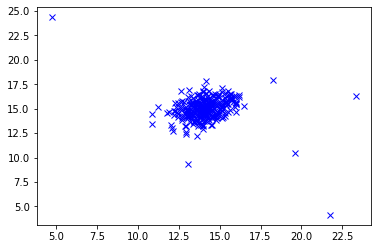

In [4]:
# 绘制出测试集的图案
plt.plot(X[:,0], X[:,1], 'bx')
plt.show()

## 3.获取训练集中样本特征的均值和方差

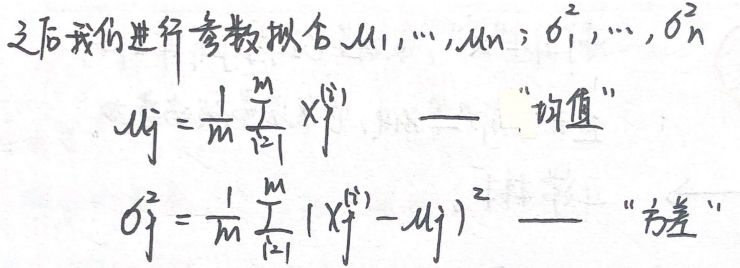

In [5]:
# 定义获得均值方差的函数
def estimateGaussian(X,isCovariance):         # isCovariance ：协方差
    means = np.mean(X,axis=0)                 # 均值
    if isCovariance:                          # 方差
        sigma2 = (X-means).T@(X-means) / len(X)
    else:
        sigma2 = np.var(X,axis=0)
    return means,sigma2

In [6]:
# 实验一下
means,sigma2 = estimateGaussian(X,isCovariance = True)
sigma2

array([[ 1.83263141, -0.22712233],
       [-0.22712233,  1.70974533]])

In [7]:
means,sigma2 = estimateGaussian(X,isCovariance = False)
sigma2

array([1.83263141, 1.70974533])

## 4.多元正态分布密度函数

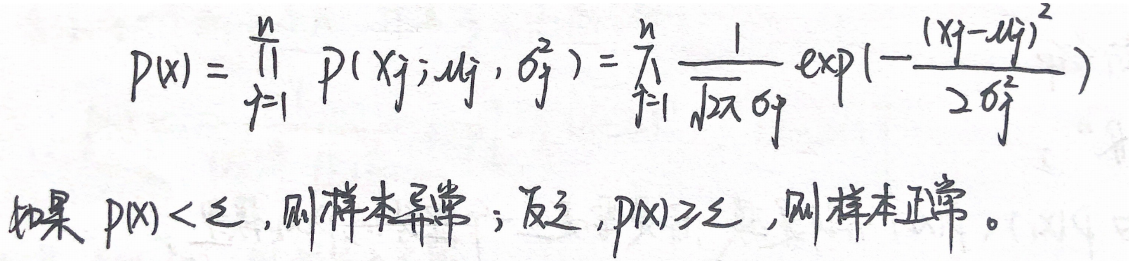

In [8]:
# 定义多元正态分布密度函数
def gaussian(X,means,sigma2):
    
    if np.ndim(sigma2) == 1:
        sigma2 = np.diag(sigma2)
     
    X = X - means
    n = X.shape[1]
    
    first = np.power(2*np.pi,-n/2)*(np.linalg.det(sigma2)**(-0.5))
    second =np.diag(X@np.linalg.inv(sigma2)@X.T) 
    p = first * np.exp(-0.5*second)
    p = p.reshape(-1,1)
    
#     m = len(X)
#     second = np.zeros(m,1)
#     for row in range(m):
#         second[row] = X[row].T @ np.linalg.inv(sigma2) @ X[row]
#     p = first * np.exp(-0.5*second)

    return p

## 5. 绘图

In [9]:
# 定义绘制高斯曲线的函数
def plotGaussian(X,means,sigma2):
    x = np.arange(0, 30, 0.5) 
    y = np.arange(0, 30, 0.5)
    
    # 画等高线的方法类似
    xx, yy = np.meshgrid(x,y)  
    z= gaussian(np.c_[xx.ravel(),yy.ravel()], means, sigma2)  # 计算对应的高斯分布函数
    zz = z.reshape(xx.shape)  
    
    plt.plot(X[:,0],X[:,1],'bx')
    contour_levels = [10**h for h in range(-20,0,3)]
    plt.contour(xx, yy, zz, contour_levels)

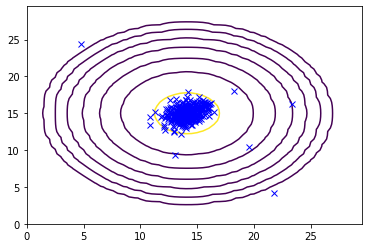

In [10]:
means,sigma2 = estimateGaussian(X,isCovariance = False)
plotGaussian(X,means,sigma2)

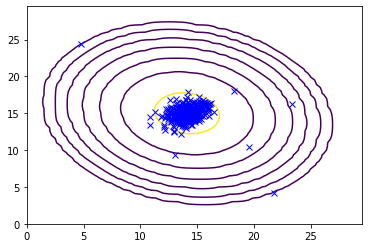

In [11]:
means,sigma2 = estimateGaussian(X,isCovariance = True)
plotGaussian(X,means,sigma2)

## 6.阈值epsilon选取

In [12]:
# 定义选择epsilon,和F1最佳值的函数
def selectThreshold(yval,p):
    
   # 设置初始值
    bestEpsilon = 0
    bestF1 = 0
    
    # 1000个epsilon的取值，选择一个最好的
    epsilons = np.linspace(min(p),max(p),1000)
    
    for e in epsilons:
        p_ = p < e
        tp = np.sum((yval == 1) & (p_ == 1))
        fp = np.sum((yval == 0) & (p_ == 1))
        fn = np.sum((yval == 1) & (p_ == 0))
        prec = tp / (tp + fp) if (tp+fp) else 0
        rec = tp / (tp + fn) if (tp+fn) else 0
        F1_e = 2 * prec * rec / (prec + rec) if (prec + rec) else 0
        
        if F1_e > bestF1:
            bestF1 = F1_e
            bestEpsilon = e
    
    return bestEpsilon,bestF1

In [13]:
# 使用之前定义的获得均值方差的函数来获取数据集的均值和方差
means,sigma2 = estimateGaussian(X,isCovariance = True)

# 使用之前定义的多元正态分布密度函数计算验证集的高斯密度
pval = gaussian(Xval,means,sigma2)

# 使用之前定义的bestEpsilon,bestF1选择函数来得到参数
bestEpsilon,bestF1 = selectThreshold(yval,pval)

In [14]:
bestEpsilon,bestF1

(array([9.07484457e-05]), 0.8750000000000001)

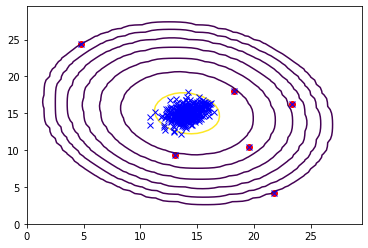

In [15]:
# 计算出数据的高斯概率
p = gaussian(X,means,sigma2)

# 遍历所有的数据点，当p[i] < bestEpsilon时判定位异常点
anoms = np.array([X[i] for i in range(X.shape[0]) if p[i] < bestEpsilon])

# 画图
plotGaussian(X,means,sigma2)
plt.scatter(anoms[:,0],anoms[:,1],c='r',marker='o')  # 将异常点有圈圈标注
plt.show()

案例2: 高维数据的异常检测

数据集：data/ex8data1.mat

### 1.导入数据集

In [16]:
# 可见这次导入的数据集有11个特征，难以可视化
mat = sio.loadmat( 'data/ex8data2.mat' )
X2 = mat['X']
Xval2, yval2 = mat['Xval'], mat['yval']
X2.shape 

(1000, 11)

In [17]:
# 在 isCovariance=True 的情况下获取均值和方差
means,sigma2 = estimateGaussian(X2,isCovariance=True)

# 根据之前的均值和方差得到高斯密度函数
pval = gaussian(Xval2,means,sigma2)

# 选择最佳的Epsilon,F1
bestEpsilon,bestF1 = selectThreshold(yval2,pval)

# 计算概率并找出异常
p = gaussian(X2,means,sigma2)
anoms = [X2[i] for i in range(len(X2)) if p[i] < bestEpsilon]
len(anoms)

122